In [1]:
import codigo
from codigo import utils
from codigo import model_utils

In [2]:
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment',None)
import matplotlib.pyplot as plt
import seaborn as sns
import math
from pickle import dump

%matplotlib inline

# Importar Dataset depurado

In [3]:
df_Inicial = pd.read_csv(r'dataset/generado/datasetDepurado.csv')

# Revisamos las columnas que contiene el Dataset

In [4]:
df_Inicial.head()

,ID,Date,Glucose level
0,LIB193263,2020-06-09 19:08:00,99.0
1,LIB193263,2020-06-09 19:23:00,92.0
2,LIB193263,2020-06-09 19:38:00,86.0
3,LIB193263,2020-06-09 19:53:00,85.0
4,LIB193263,2020-06-09 20:08:00,85.0


In [5]:
df_Inicial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2966685 entries, 0 to 2966684
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   ID             object 
 1   Date           object 
 2   Glucose level  float64
dtypes: float64(1), object(2)
memory usage: 67.9+ MB


### Cambiamos el formato de la columna Date de object a datetime64

In [6]:
df_Inicial['Date']=pd.to_datetime(df_Inicial['Date'])

In [7]:
df_Inicial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2966685 entries, 0 to 2966684
Data columns (total 3 columns):
 #   Column         Dtype         
---  ------         -----         
 0   ID             object        
 1   Date           datetime64[ns]
 2   Glucose level  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 67.9+ MB


In [8]:
df_Inicial['Date'].min()

Timestamp('2018-01-06 00:31:00')

In [9]:
df_Inicial['Date'].max()

Timestamp('2022-03-20 23:58:00')

# Iniciamos Análisis Exploratorio

## Sobre el conjunto de datos depurado

In [10]:
from pandas_profiling import ProfileReport
profile = ProfileReport(
    df_Inicial,
    missing_diagrams={
          'heatmap': True,
          'dendrogram': False,
      },
    correlations={
         "kendall": {"calculate": False},
         "phi_k": {"calculate": False},
         "cramers": {"calculate": False},
         "pearson": {"calculate": True,"threshold":0.8,"warn_high_correlations":True}
        
     }
)

C:\Users\wm_herrera\Anaconda3\envs\tensorflow_keras\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
profile.to_file("analisisExploratorio/datasetDepurado.html")

Summarize dataset:  36%|███▋      | 4/11 [00:15<00:26,  3.76s/it, Calculate pearson correlation] C:\Users\wm_herrera\Anaconda3\envs\tensorflow_keras\lib\site-packages\multimethod\__init__.py:315: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return func(*args, **kwargs)
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]


## Sobre el conjunto de un paciente

In [12]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))
scalerHours = load(open('dataset/generado/scalerHours.scaler', 'rb'))
scalerMin = load(open('dataset/generado/scalerMin.scaler', 'rb'))
scalerPodId = load(open('dataset/generado/scalerPodId.scaler', 'rb'))
scalerLevelId = load(open('dataset/generado/scalerLevelId.scaler', 'rb'))

In [13]:
pacienteID="LIB193277"
paciente_data = utils.getDataPatient(df_Inicial,pacienteID,'15min',False)
paciente_data=utils.fillNullData(paciente_data,'interpolate_linear')
paciente_data=utils.generateNewColumns(paciente_data,scalerLevelId,scalerHours,scalerMin,scalerPodId,scalerGlucosa,False)

C:\Users\wm_herrera\Desktop\celular\Maestria IA\Tesis\Glucose Tesis\GitHub Repo\tfm-forecasting-glucose\codigo\utils.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ret= ret.resample(frequency).mean()


In [14]:
paciente_data

,Glucose level,level_label,level_id,hour,min,pod_label,pod_id
Date,,,,,,,
2018-06-12 20:15:00,156.0,euglycemia,0,20,15,Eve,4
2018-06-12 20:30:00,163.0,euglycemia,0,20,30,Eve,4
2018-06-12 20:45:00,158.0,euglycemia,0,20,45,Eve,4
2018-06-12 21:00:00,167.0,euglycemia,0,21,0,Night,5
2018-06-12 21:15:00,139.0,euglycemia,0,21,15,Night,5
...,...,...,...,...,...,...,...
2022-03-18 10:45:00,153.0,euglycemia,0,10,45,Morning,2
2022-03-18 11:00:00,144.0,euglycemia,0,11,0,Morning,2
2022-03-18 11:15:00,134.0,euglycemia,0,11,15,Morning,2


In [15]:
from pandas_profiling import ProfileReport
profile = ProfileReport(paciente_data, tsmode=True, sortby="Date"
    ,missing_diagrams={
          'heatmap': True,
          'dendrogram': False,
      },
    correlations={
         "kendall": {"calculate": False},
         "phi_k": {"calculate": False},
         "cramers": {"calculate": False},
         "pearson": {"calculate": True,"threshold":0.8,"warn_high_correlations":True}
        
     })

In [16]:
profile.to_file("analisisExploratorio/paciente_LIB193277.html")

Summarize dataset:   8%|▊         | 1/12 [00:01<00:11,  1.04s/it, Describe variable:pod_label]  C:\Users\wm_herrera\Anaconda3\envs\tensorflow_keras\lib\site-packages\multimethod\__init__.py:315: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  return func(*args, **kwargs)
C:\Users\wm_herrera\Anaconda3\envs\tensorflow_keras\lib\site-packages\multimethod\__init__.py:315: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  return func(*args, **kwargs)
C:\Users\wm_herrera\Anaconda3\envs\tensorflow_keras\lib\site-packages\multimethod\__init__.py:315: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  return func(*args, **kwargs)
C:\Users\wm_herrera\Anaconda3\envs\te

##  Análisis de correlación

In [17]:
features=['Glucose level','hour','min','pod_id','level_id']

In [18]:
paciente_df=paciente_data[features].copy()
correlation_matrix = paciente_df.corr()            
correlation_matrix

,Glucose level,hour,min,pod_id,level_id
Glucose level,1.000000,0.052338,-0.000714,0.058993,0.666557
hour,0.052338,1.000000,0.000012,0.010564,0.051592
min,-0.000714,0.000012,1.000000,0.000003,0.000780
pod_id,0.058993,0.010564,0.000003,1.000000,0.043213
level_id,0.666557,0.051592,0.000780,0.043213,1.000000


In [19]:
correlated_features = set()
correlated_features = correlation_matrix.index[abs(correlation_matrix["Glucose level"])>0.5]
correlated_features

Index(['Glucose level', 'level_id'], dtype='object')

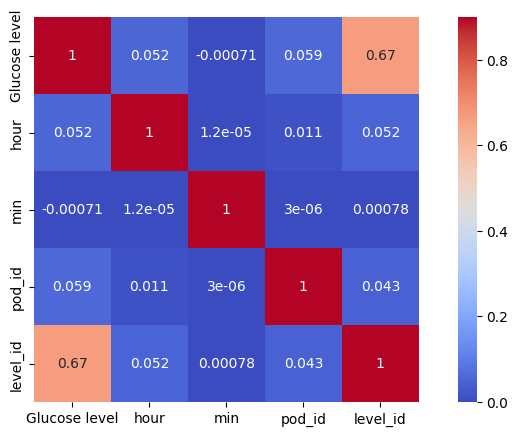

In [20]:
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix,  vmax=.9, square=True, annot=True,cmap='coolwarm')
plt.show()

##  Análisis de balanceo de clases

### Clase: Hora del día

<AxesSubplot: >

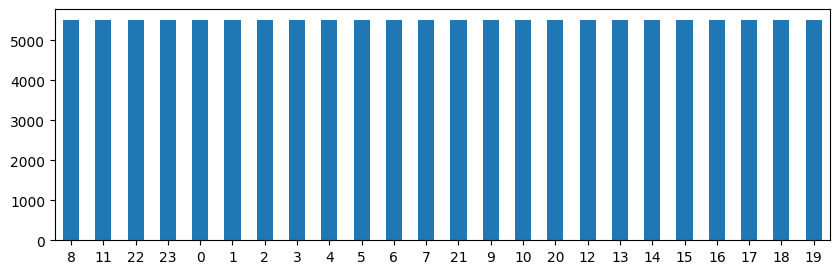

In [21]:
paciente_data['hour'].value_counts().plot.bar( rot=0,figsize=(10, 3))

### Clase: Parte del día

<AxesSubplot: >

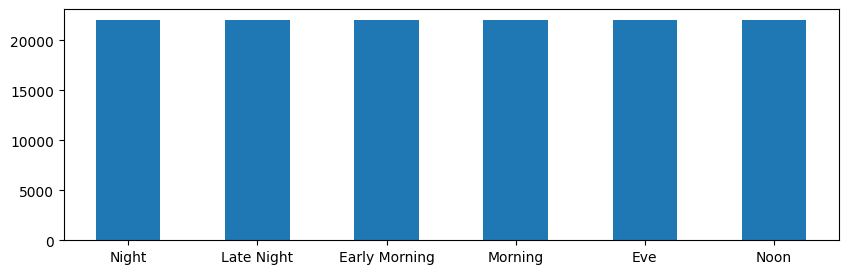

In [22]:
paciente_data['pod_label'].value_counts().plot.bar( rot=0,figsize=(10, 3))

### Clase: Niveles de Glucosa

In [23]:
paciente_data['level_label'].value_counts()

euglycemia       117575
hyperglycemia      8087
hypoglycemia       6305
Name: level_label, dtype: int64

<AxesSubplot: >

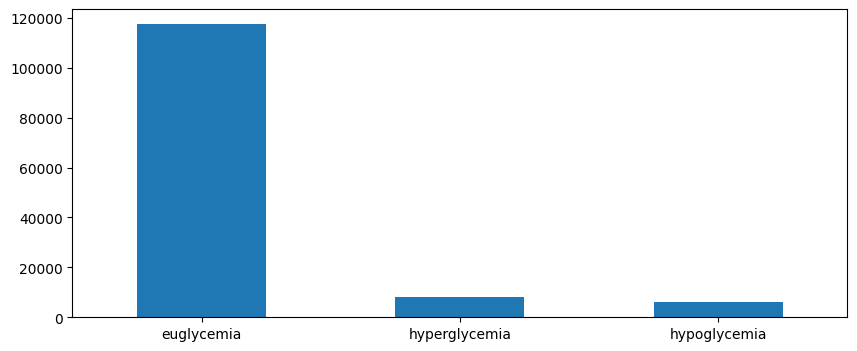

In [24]:
paciente_data['level_label'].value_counts().plot.bar( rot=0,figsize=(10, 4))

<AxesSubplot: ylabel='level_label'>

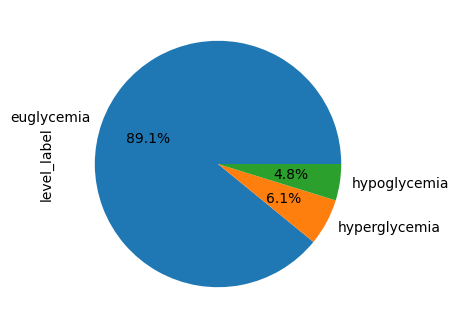

In [25]:
paciente_data['level_label'].value_counts().plot.pie(y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))